## Import Libraries for Preprocessing

In [2]:
#Import libraries 
import os
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

In [3]:
import pandas as pd
import random 
import shutil
from tqdm import tqdm
import PIL 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

## Creating Directories and Moving files

In [4]:
DATASET = "D:/DOWNLOADS_EXEC/EuroSAT/2750/"

In [5]:
LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [6]:
# Basic parameters 
TRAIN_DIR = "D:/DOWNLOADS_EXEC/EuroSAT/training/"
TEST_DIR = "D:/DOWNLOADS_EXEC/EuroSAT/testing/"
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# Create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

In [7]:
# Create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [8]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub("D:/DOWNLOADS_EXEC/EuroSAT/2750/", "D:/DOWNLOADS_EXEC/EuroSAT/training/", i) for i in train_paths]
    new_test_paths = [re.sub("D:/DOWNLOADS_EXEC/EuroSAT/2750/", "D:/DOWNLOADS_EXEC/EuroSAT/testing/", i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  0%|          | 46/21600 [00:00<00:53, 405.01it/s]

moving training files..


  8%|▊         | 425/5400 [00:00<00:01, 4027.02it/s]

moving testing files..


100%|██████████| 5400/5400 [00:00<00:00, 13872.13it/s]


## ImageDataGenerator Instance for data augmentation

In [9]:
 #Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [10]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [11]:
np.save('class_indices', train_generator.class_indices)

In [12]:
#MAchine learning 
# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


## Creating mini batch

In [14]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

## Running the training  

In [13]:
# import random forest classifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score


In [15]:
# Monitor time taken HERE ! 
#train 
import time
start = time.time()

rf_clf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

end = time.time()


Accuracy Score: 0.6231


## Generating evaluation metrics 

In [26]:

from sklearn.metrics import confusion_matrix, classification_report
target_names=LABELS
print(confusion_matrix(rf_test_generator.classes, y_pred))
print ("Classification report : Random Forest")
print(classification_report(rf_test_generator.classes, y_pred, target_names=target_names))


[[434   3  26  25  17  17  35  11  25   7]
 [  0 545   4   0   0  21   0   1   6  23]
 [ 49  16 325  28  29   9  58  54  27   5]
 [ 75  17  43 131  31  27  30  64  82   0]
 [ 16   0  14  24 395   2   8  38   3   0]
 [  8  15  48  15   3 274   9  13  14   1]
 [117   1 100  21  17  17 156  63   8   0]
 [ 41   1  82  40  56   5  47 319   9   0]
 [ 47  43  14  52  11  24   7  32 266   4]
 [  0  53   3   0   0  11   0   4   9 520]]
Classification report : Random Forest
                      precision    recall  f1-score   support

          AnnualCrop       0.55      0.72      0.63       600
              Forest       0.79      0.91      0.84       600
HerbaceousVegetation       0.49      0.54      0.52       600
             Highway       0.39      0.26      0.31       500
          Industrial       0.71      0.79      0.75       500
             Pasture       0.67      0.69      0.68       400
       PermanentCrop       0.45      0.31      0.37       500
         Residential       0.53   

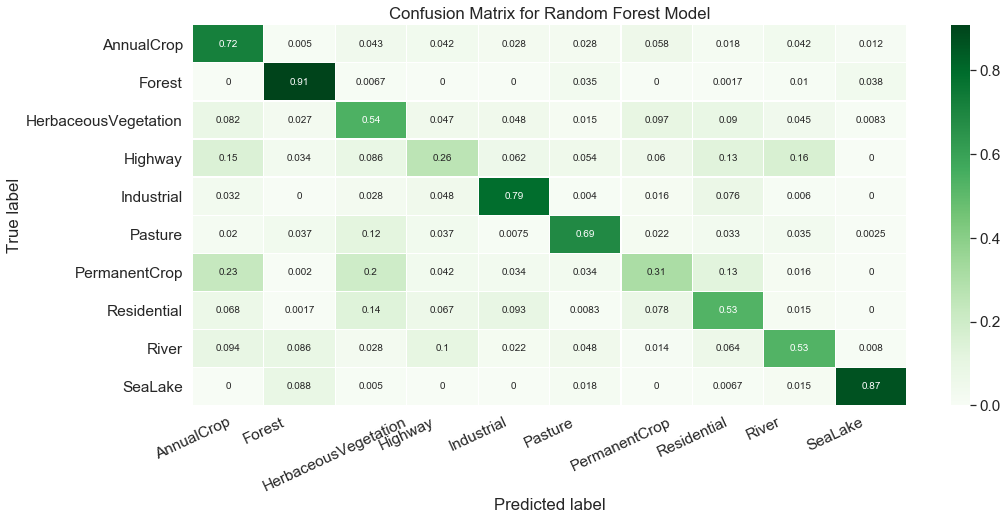

In [21]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(rf_test_generator.classes, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = LABELS
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()